In [20]:
!pip install pyhealth

In [21]:
!pip install pandas==1.3.5 numpy==1.21.6


^C


In [ ]:
from pyhealth.datasets import MIMIC3Dataset
from pandarallel import pandarallel

mimic3_ds = MIMIC3Dataset(
        root="C:/Users/nitiy/OneDrive - The Pennsylvania State University/ds 340w/mimic-sub-test", 
        tables=["LABEVENTS", "DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        refresh_cache=True,
)

mimic3_ds.stat()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
finish basic patient information parsing : 22.1038658618927s
finish parsing LABEVENTS : 372.00586318969727s
finish parsing DIAGNOSES_ICD : 23.60004687309265s
finish parsing PROCEDURES_ICD : 15.557785987854004s
finish parsing PRESCRIPTIONS : 68.19453310966492s


Mapping codes: 100%|██████████| 23692/23692 [00:01<00:00, 13928.64it/s]



Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 23692
	- Number of visits: 26836
	- Number of visits per patient: 1.1327
	- Number of events per visit in LABEVENTS: 0.0000
	- Number of events per visit in DIAGNOSES_ICD: 8.3969
	- Number of events per visit in PROCEDURES_ICD: 4.2112
	- Number of events per visit in PRESCRIPTIONS: 53.4297



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 23692\n\t- Number of visits: 26836\n\t- Number of visits per patient: 1.1327\n\t- Number of events per visit in LABEVENTS: 0.0000\n\t- Number of events per visit in DIAGNOSES_ICD: 8.3969\n\t- Number of events per visit in PROCEDURES_ICD: 4.2112\n\t- Number of events per visit in PRESCRIPTIONS: 53.4297\n'

In [5]:
from pyhealth.tasks import mortality_prediction_mimic3_fn

mimic3_ds_task = mimic3_ds.set_task(task_fn=mortality_prediction_mimic3_fn)
# stats info
mimic3_ds_task.stat()

Generating samples for mortality_prediction_mimic3_fn: 100%|██████████| 23692/23692 [00:00<00:00, 112183.22it/s]


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: mortality_prediction_mimic3_fn
	- Number of samples: 2313
	- Number of patients: 1663
	- Number of visits: 2313
	- Number of visits per patient: 1.3909
	- conditions:
		- Number of conditions per sample: 11.7920
		- Number of unique conditions: 2127
		- Distribution of conditions (Top-10): [('4280', 893), ('4019', 741), ('42731', 710), ('5849', 533), ('51881', 472), ('25000', 452), ('41401', 441), ('5990', 405), ('40391', 314), ('496', 293)]
	- procedures:
		- Number of procedures per sample: 5.3921
		- Number of unique procedures: 763
		- Distribution of procedures (Top-10): [('3893', 971), ('9904', 817), ('966', 624), ('9604', 586), ('9672', 438), ('9671', 426), ('3995', 297), ('9915', 286), ('3891', 267), ('9907', 243)]
	- drugs:
		- Number of drugs per sample: 45.2300
		- Number of unique drugs: 2345
		- Distribution of drugs (Top-10): [('0.0', 2264), ('641040025.0', 1466), ('8084199.0', 1454), ('338001702.0', 1278), 

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: mortality_prediction_mimic3_fn\n\t- Number of samples: 2313\n\t- Number of patients: 1663\n\t- Number of visits: 2313\n\t- Number of visits per patient: 1.3909\n\t- conditions:\n\t\t- Number of conditions per sample: 11.7920\n\t\t- Number of unique conditions: 2127\n\t\t- Distribution of conditions (Top-10): [('4280', 893), ('4019', 741), ('42731', 710), ('5849', 533), ('51881', 472), ('25000', 452), ('41401', 441), ('5990', 405), ('40391', 314), ('496', 293)]\n\t- procedures:\n\t\t- Number of procedures per sample: 5.3921\n\t\t- Number of unique procedures: 763\n\t\t- Distribution of procedures (Top-10): [('3893', 971), ('9904', 817), ('966', 624), ('9604', 586), ('9672', 438), ('9671', 426), ('3995', 297), ('9915', 286), ('3891', 267), ('9907', 243)]\n\t- drugs:\n\t\t- Number of drugs per sample: 45.2300\n\t\t- Number of unique drugs: 2345\n\t\t- Distribution of drugs (Top-10): [('0.0', 2264), ('641040025.0', 1466)

In [207]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds_task, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

In [208]:
from pyhealth.models import Agent

model = Agent(
    dataset=mimic3_ds_task,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["conditions", "procedures", "drugs"],
    label_key="label",
    mode="binary",
)

In [209]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=5,
    monitor="pr_auc",
)

from pyhealth.metrics.binary import binary_metrics_fn
y_true, y_prob, loss = trainer.inference(test_loader)
binary_metrics_fn(y_true, y_prob, metrics=["pr_auc", "roc_auc", "f1"])

Agent(
  (embeddings): ModuleDict(
    (conditions): Embedding(2129, 128, padding_idx=0)
    (procedures): Embedding(765, 128, padding_idx=0)
    (drugs): Embedding(2347, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (agent): ModuleDict(
    (conditions): AgentLayer(
      (agent1_fc1): Linear(in_features=128, out_features=64, bias=True)
      (agent2_fc1): Linear(in_features=128, out_features=64, bias=True)
      (agent1_fc2): Linear(in_features=64, out_features=10, bias=True)
      (agent2_fc2): Linear(in_features=64, out_features=10, bias=True)
      (agent1_value): Linear(in_features=64, out_features=1, bias=True)
      (agent2_value): Linear(in_features=64, out_features=1, bias=True)
      (rnn): GRUCell(128, 128)
      (nn_dropout): Dropout(p=0.5, inplace=False)
      (sigmoid): Sigmoid()
      (softmax): Softmax(dim=1)
      (tanh): Tanh()
      (relu): ReLU()
    )
    (procedures): AgentLayer(
      (agent1_fc1): Linear(in_features=128, out_features=64, bias=True)


Epoch 0 / 5: 100%|██████████| 29/29 [00:01<00:00, 15.08it/s]

--- Train epoch-0, step-29 ---
loss: -2.8407



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 37.23it/s]

--- Eval epoch-0, step-29 ---
pr_auc: 0.1442
roc_auc: 0.4738
f1: 0.0000
loss: -4.1739
New best pr_auc score (0.1442) at epoch-0, step-29




Epoch 1 / 5: 100%|██████████| 29/29 [00:02<00:00, 13.67it/s]

--- Train epoch-1, step-58 ---
loss: -5.0338



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 47.11it/s]

--- Eval epoch-1, step-58 ---
pr_auc: 0.1153
roc_auc: 0.4893
f1: 0.0000
loss: -5.5763




Epoch 2 / 5: 100%|██████████| 29/29 [00:02<00:00, 12.89it/s]

--- Train epoch-2, step-87 ---
loss: -6.2563



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 30.65it/s]

--- Eval epoch-2, step-87 ---
pr_auc: 0.1272
roc_auc: 0.5127
f1: 0.0000


loss: -6.4543



Epoch 3 / 5: 100%|██████████| 29/29 [00:02<00:00, 13.17it/s]

--- Train epoch-3, step-116 ---
loss: -6.9531



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 35.09it/s]

--- Eval epoch-3, step-116 ---
pr_auc: 0.1201
roc_auc: 0.5271
f1: 0.0000
loss: -6.6598




Epoch 4 / 5: 100%|██████████| 29/29 [00:02<00:00, 13.78it/s]

--- Train epoch-4, step-145 ---
loss: -7.0512



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 19.07it/s]

--- Eval epoch-4, step-145 ---
pr_auc: 0.1351
roc_auc: 0.5323
f1: 0.0000
loss: -6.5883
Loaded best model



Evaluation: 100%|██████████| 4/4 [00:00<00:00, 26.68it/s]


{'pr_auc': 0.16043059881502147, 'roc_auc': 0.5730188679245283, 'f1': 0.0}

In [218]:
import torch

# Define the path where you want to save the model
model_save_path = r"C:\Users\nitiy\OneDrive - The Pennsylvania State University\ds 340w\trained_model.pth"

# Save the trained model
torch.save(trainer.model.state_dict(), model_save_path)

In [ ]:
import torch
from pyhealth.models import Agent

test = Agent(
    dataset=mimic3_ds_task,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["conditions", "procedures", "drugs"],
    label_key="label",
    mode="binary",
)

model_save_path = r"C:\Users\nitiy\OneDrive - The Pennsylvania State University\ds 340w\trained_model.pth"

# Load the state_dict from the saved model file
test.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode if you are making predictions
test.eval()

Agent(
  (embeddings): ModuleDict(
    (conditions): Embedding(2129, 128, padding_idx=0)
    (procedures): Embedding(765, 128, padding_idx=0)
    (drugs): Embedding(2347, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (agent): ModuleDict(
    (conditions): AgentLayer(
      (agent1_fc1): Linear(in_features=128, out_features=64, bias=True)
      (agent2_fc1): Linear(in_features=128, out_features=64, bias=True)
      (agent1_fc2): Linear(in_features=64, out_features=10, bias=True)
      (agent2_fc2): Linear(in_features=64, out_features=10, bias=True)
      (agent1_value): Linear(in_features=64, out_features=1, bias=True)
      (agent2_value): Linear(in_features=64, out_features=1, bias=True)
      (rnn): GRUCell(128, 128)
      (nn_dropout): Dropout(p=0.5, inplace=False)
      (sigmoid): Sigmoid()
      (softmax): Softmax(dim=1)
      (tanh): Tanh()
      (relu): ReLU()
    )
    (procedures): AgentLayer(
      (agent1_fc1): Linear(in_features=128, out_features=64, bias=True)


In [122]:
for name, module in model.named_modules():
    print(name, ":", module.__class__.__name__)

 : Agent
embeddings : ModuleDict
embeddings.conditions : Embedding
embeddings.procedures : Embedding
embeddings.drugs : Embedding
linear_layers : ModuleDict
agent : ModuleDict
agent.conditions : AgentLayer
agent.conditions.agent1_fc1 : Linear
agent.conditions.agent2_fc1 : Linear
agent.conditions.agent1_fc2 : Linear
agent.conditions.agent2_fc2 : Linear
agent.conditions.agent1_value : Linear
agent.conditions.agent2_value : Linear
agent.conditions.rnn : GRUCell
agent.conditions.nn_dropout : Dropout
agent.conditions.sigmoid : Sigmoid
agent.conditions.softmax : Softmax
agent.conditions.tanh : Tanh
agent.conditions.relu : ReLU
agent.procedures : AgentLayer
agent.procedures.agent1_fc1 : Linear
agent.procedures.agent2_fc1 : Linear
agent.procedures.agent1_fc2 : Linear
agent.procedures.agent2_fc2 : Linear
agent.procedures.agent1_value : Linear
agent.procedures.agent2_value : Linear
agent.procedures.rnn : GRUCell
agent.procedures.nn_dropout : Dropout
agent.procedures.sigmoid : Sigmoid
agent.proce

In [300]:
from itertools import chain

# === Utility: Flatten List ===
def flatten_list(l):
    return list(chain.from_iterable(l))

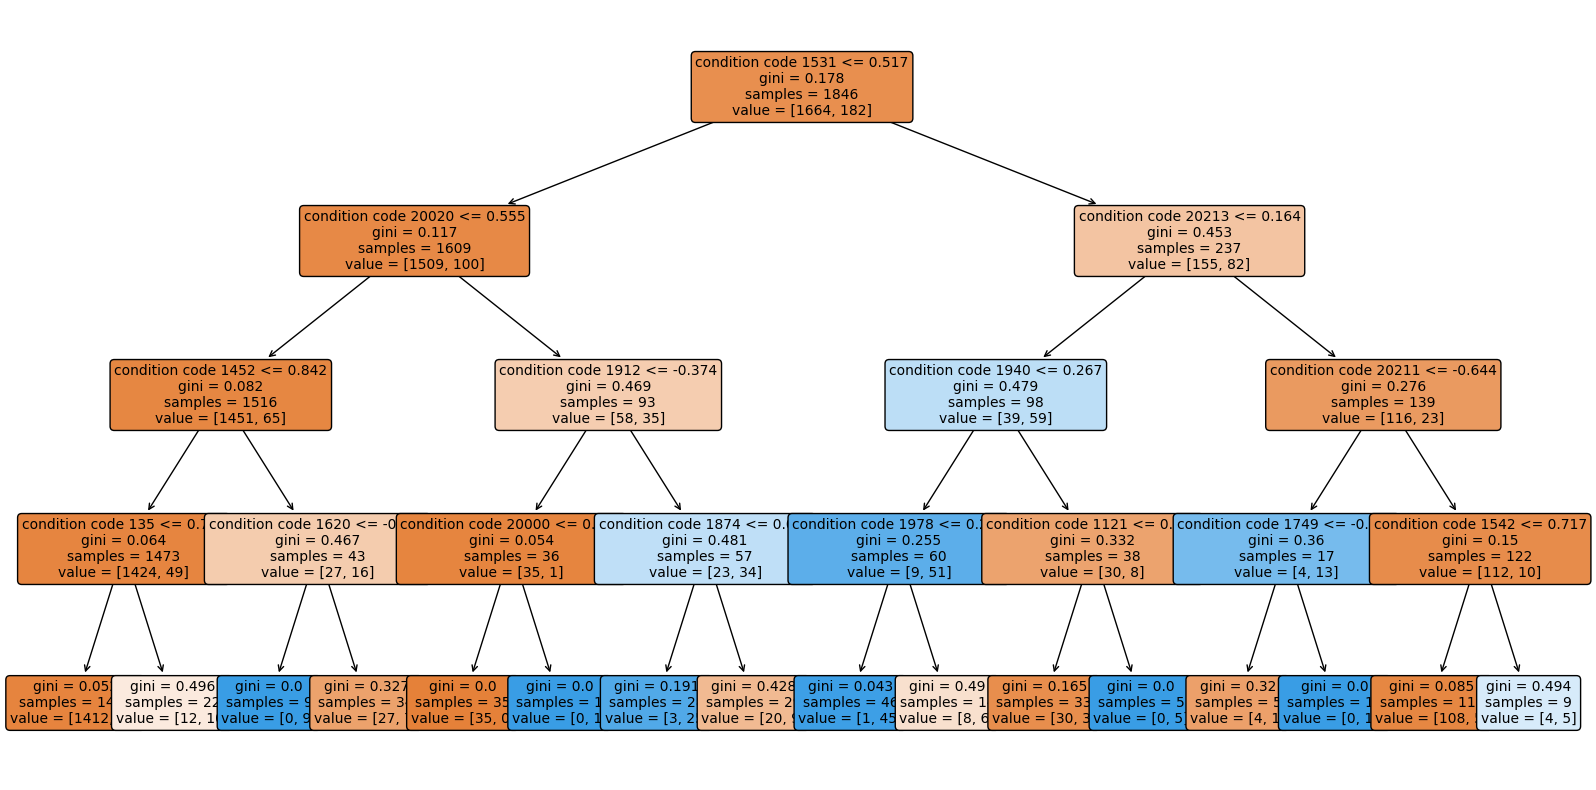

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1664
           1       0.93      0.56      0.70       182

    accuracy                           0.95      1846
   macro avg       0.94      0.78      0.84      1846
weighted avg       0.95      0.95      0.95      1846



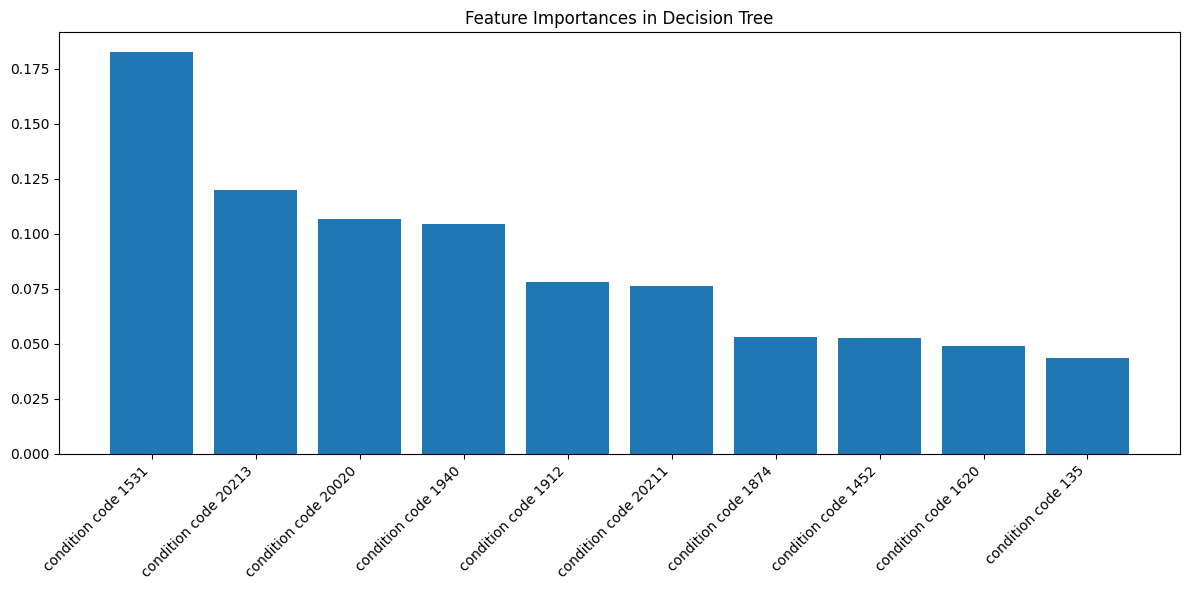

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# === STEP 1: Hook for Embedding Extraction ===
activation = {}

def get_activation(name):
    def hook(test, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

def get_submodule(test, submodule_key):
    for key in submodule_key.split("."):
        test = getattr(test, key)
    return test

# === STEP 2: Register Hook ===
hook_layer_names = [
    'agent.conditions.rnn'
]

hook_handles = []

# Register hooks and store handles for later removal
for hook_layer_name in hook_layer_names:
    hooked_layer = get_submodule(test, hook_layer_name)
    handle = hooked_layer.register_forward_hook(get_activation(hook_layer_name))
    hook_handles.append(handle)

# === STEP 3: Loop Through Data and Collect Embeddings + Labels ===
X, y = [], []

test.eval()
with torch.no_grad():
    for batch in train_loader:
        _ = test(**batch)  # trigger all hooks
        
        # Collect and concatenate activations from all hooked layers
        batch_embeddings = []
        for name in hook_layer_names:
            batch_embeddings.append(activation[name])
        
        # Stack along feature axis (dim=1) and add to dataset
        concatenated = np.concatenate(batch_embeddings, axis=1)
        X.extend(concatenated)
        y.extend(batch["label"])

# === Build Feature Mapping ===
def build_feature_mapping(dataset):
    all_conditions = set()
    all_procedures = set()
    all_drugs = set()

    for sample in dataset:
        all_conditions.update(flatten_list(sample.get('conditions', [])))
        all_procedures.update(flatten_list(sample.get('procedures', [])))
        all_drugs.update(flatten_list(sample.get('drugs', [])))

    condition_list = sorted(all_conditions)
    procedure_list = sorted(all_procedures)
    drug_list = sorted(all_drugs)
    feature_list = condition_list

    index_to_feature = {}
    for i, code in enumerate(feature_list):
        if i < len(condition_list):
            ftype = "condition"
        elif i < len(condition_list) + len(procedure_list):
            ftype = "procedure"
        else:
            ftype = "drug"
        index_to_feature[i] = {"code": code, "type": "condition"}

    return index_to_feature

index_to_feature = build_feature_mapping(mimic3_ds_task)

# === STEP 4: Fit Decision Tree ===
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# === STEP 5: Print the Tree ===
readable_feature_names = []
for i in range(X[0].shape[0]):
    if i in index_to_feature:
        info = index_to_feature[i]
        readable_feature_names.append(f"{info['type']} code {info['code']}")
    else:
        readable_feature_names.append(f"unknown_{i}")

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=readable_feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

# === Optional: Evaluate Performance ===
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

# === STEP 6: Unregister All Hooks ===
for handle in hook_handles:
    handle.remove()


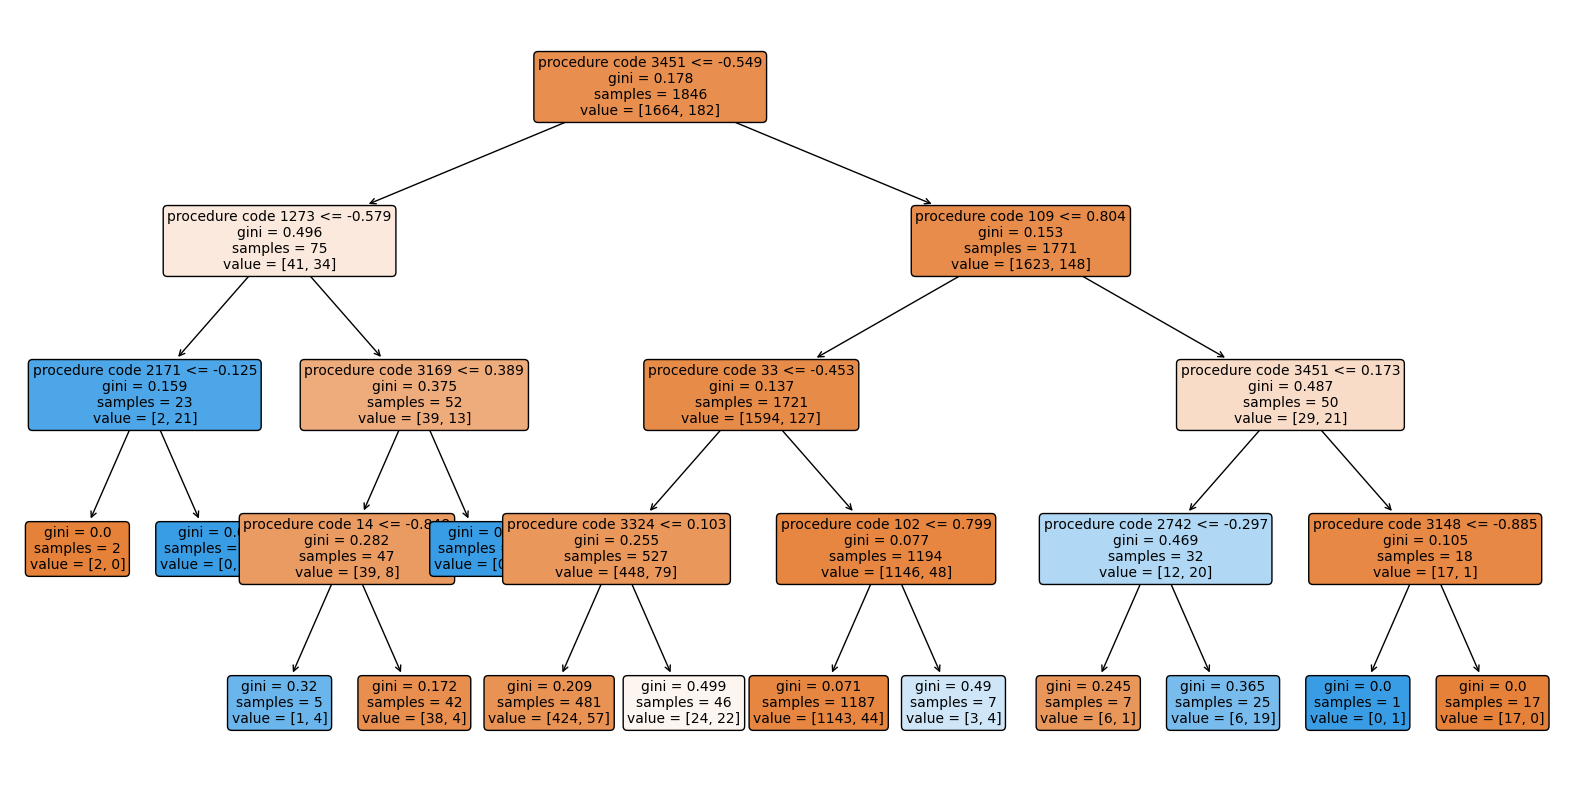

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1664
           1       0.84      0.30      0.44       182

    accuracy                           0.93      1846
   macro avg       0.89      0.65      0.70      1846
weighted avg       0.92      0.93      0.91      1846



In [303]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# === STEP 1: Hook for Embedding Extraction ===
activation = {}

def get_activation(name):
    def hook(test, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

def get_submodule(test, submodule_key):
    for key in submodule_key.split("."):
        test = getattr(test, key)
    return test

# === STEP 2: Register Hook ===
hook_layer_names = [
    'agent.procedures.rnn'
]

hook_handles = []

# Register hooks and store handles for later removal
for hook_layer_name in hook_layer_names:
    hooked_layer = get_submodule(test, hook_layer_name)
    handle = hooked_layer.register_forward_hook(get_activation(hook_layer_name))
    hook_handles.append(handle)

# === STEP 3: Loop Through Data and Collect Embeddings + Labels ===
X, y = [], []

test.eval()
with torch.no_grad():
    for batch in train_loader:
        _ = test(**batch)  # trigger all hooks
        
        # Collect and concatenate activations from all hooked layers
        batch_embeddings = []
        for name in hook_layer_names:
            batch_embeddings.append(activation[name])
        
        # Stack along feature axis (dim=1) and add to dataset
        concatenated = np.concatenate(batch_embeddings, axis=1)
        X.extend(concatenated)
        y.extend(batch["label"])

# === Build Feature Mapping ===
# === Build Feature Mapping ===
def build_feature_mapping(dataset):
    all_conditions = set()
    all_procedures = set()
    all_drugs = set()

    for sample in dataset:
        all_conditions.update(flatten_list(sample.get('conditions', [])))
        all_procedures.update(flatten_list(sample.get('procedures', [])))
        all_drugs.update(flatten_list(sample.get('drugs', [])))

    condition_list = sorted(all_conditions)
    procedure_list = sorted(all_procedures)
    drug_list = sorted(all_drugs)
    feature_list = procedure_list

    index_to_feature = {}
    for i, code in enumerate(feature_list):
        if i < len(condition_list):
            ftype = "condition"
        elif i < len(condition_list) + len(procedure_list):
            ftype = "procedure"
        else:
            ftype = "drug"
        index_to_feature[i] = {"code": code, "type": "procedure"}

    return index_to_feature

index_to_feature = build_feature_mapping(mimic3_ds_task)

# === STEP 4: Fit Decision Tree ===
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# === STEP 5: Print the Tree ===
readable_feature_names = []
for i in range(X[0].shape[0]):
    if i in index_to_feature:
        info = index_to_feature[i]
        readable_feature_names.append(f"{info['type']} code {info['code']}")
    else:
        readable_feature_names.append(f"unknown_{i}")

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=readable_feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

# === Optional: Evaluate Performance ===
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

# === STEP 6: Unregister All Hooks ===
for handle in hook_handles:
    handle.remove()

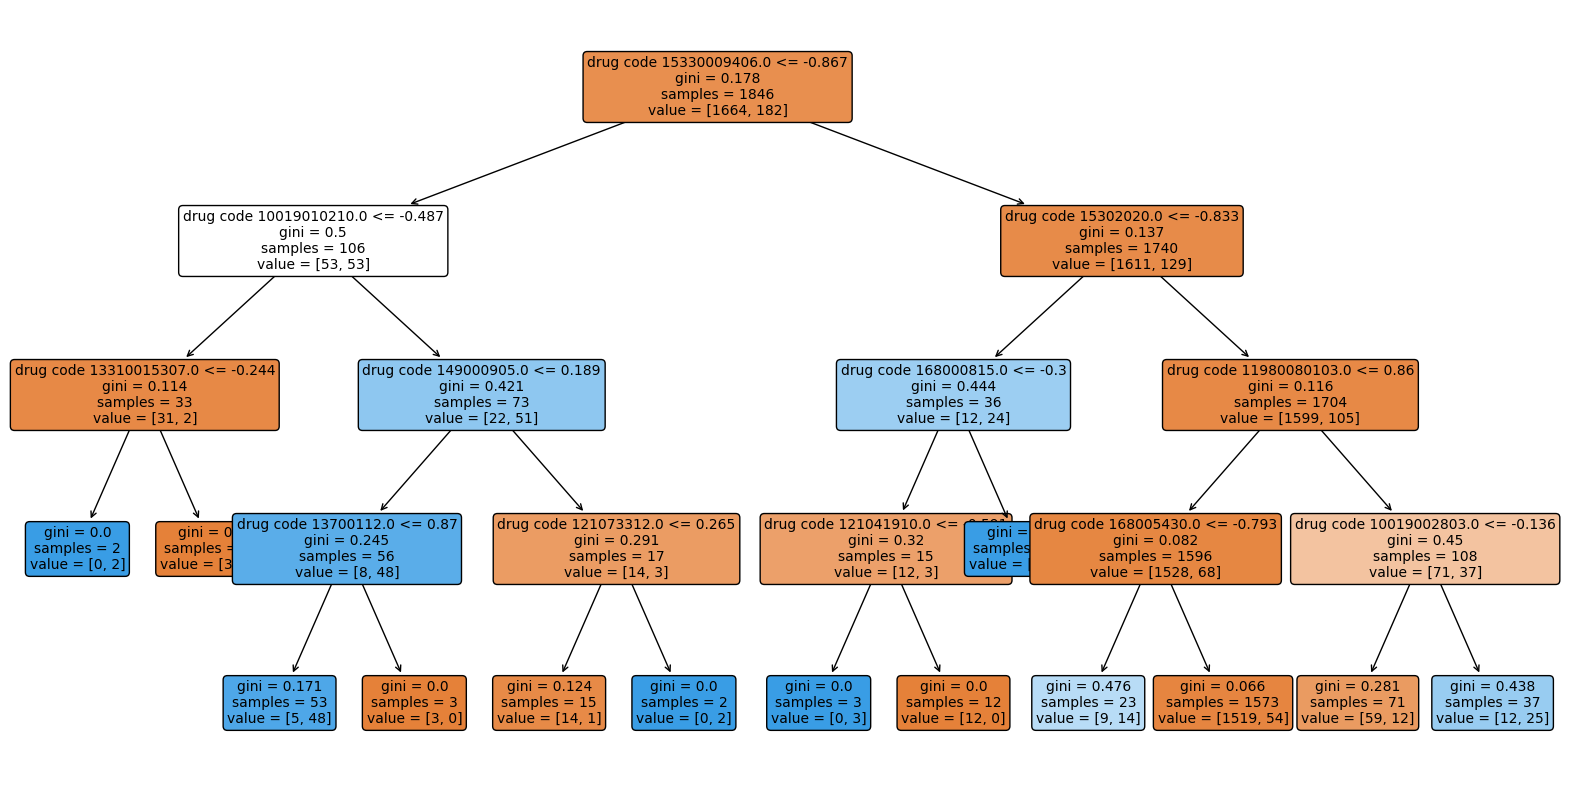

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1664
           1       0.82      0.63      0.71       182

    accuracy                           0.95      1846
   macro avg       0.89      0.81      0.84      1846
weighted avg       0.95      0.95      0.95      1846



In [304]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# === STEP 1: Hook for Embedding Extraction ===
activation = {}

def get_activation(name):
    def hook(test, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

def get_submodule(test, submodule_key):
    for key in submodule_key.split("."):
        test = getattr(test, key)
    return test

# === STEP 2: Register Hook ===
hook_layer_names = [
    'agent.drugs.rnn'
]

hook_handles = []

# Register hooks and store handles for later removal
for hook_layer_name in hook_layer_names:
    hooked_layer = get_submodule(test, hook_layer_name)
    handle = hooked_layer.register_forward_hook(get_activation(hook_layer_name))
    hook_handles.append(handle)

# === STEP 3: Loop Through Data and Collect Embeddings + Labels ===
X, y = [], []

test.eval()
with torch.no_grad():
    for batch in train_loader:
        _ = test(**batch)  # trigger all hooks
        
        # Collect and concatenate activations from all hooked layers
        batch_embeddings = []
        for name in hook_layer_names:
            batch_embeddings.append(activation[name])
        
        # Stack along feature axis (dim=1) and add to dataset
        concatenated = np.concatenate(batch_embeddings, axis=1)
        X.extend(concatenated)
        y.extend(batch["label"])

# === Build Feature Mapping ===
def build_feature_mapping(dataset):
    all_conditions = set()
    all_procedures = set()
    all_drugs = set()

    for sample in dataset:
        all_conditions.update(flatten_list(sample.get('conditions', [])))
        all_procedures.update(flatten_list(sample.get('procedures', [])))
        all_drugs.update(flatten_list(sample.get('drugs', [])))

    condition_list = sorted(all_conditions)
    procedure_list = sorted(all_procedures)
    drug_list = sorted(all_drugs)
    feature_list = drug_list

    index_to_feature = {}
    for i, code in enumerate(feature_list):
        if i < len(condition_list):
            ftype = "condition"
        elif i < len(condition_list) + len(procedure_list):
            ftype = "procedure"
        else:
            ftype = "drug"
        index_to_feature[i] = {"code": code, "type": "drug"}

    return index_to_feature

index_to_feature = build_feature_mapping(mimic3_ds_task)

# === STEP 4: Fit Decision Tree ===
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# === STEP 5: Print the Tree ===
readable_feature_names = []
for i in range(X[0].shape[0]):
    if i in index_to_feature:
        info = index_to_feature[i]
        readable_feature_names.append(f"{info['type']} code {info['code']}")
    else:
        readable_feature_names.append(f"unknown_{i}")

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=readable_feature_names, filled=True, rounded=True, fontsize=10)
plt.show()
# === Optional: Evaluate Performance ===
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

# === STEP 6: Unregister All Hooks ===
for handle in hook_handles:
    handle.remove()

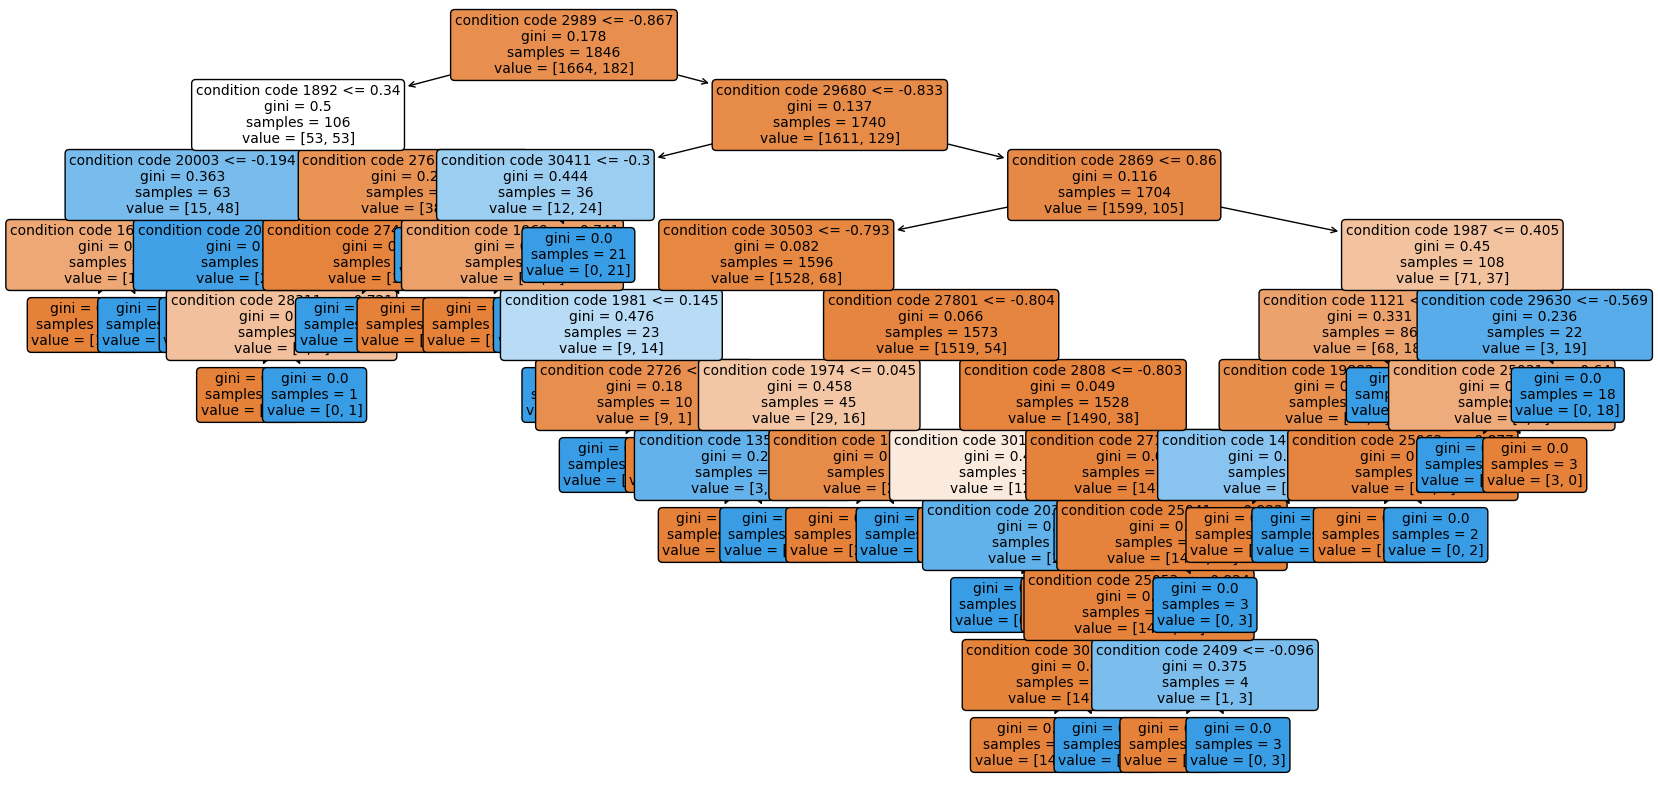

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1664
           1       1.00      0.91      0.95       182

    accuracy                           0.99      1846
   macro avg       1.00      0.96      0.97      1846
weighted avg       0.99      0.99      0.99      1846



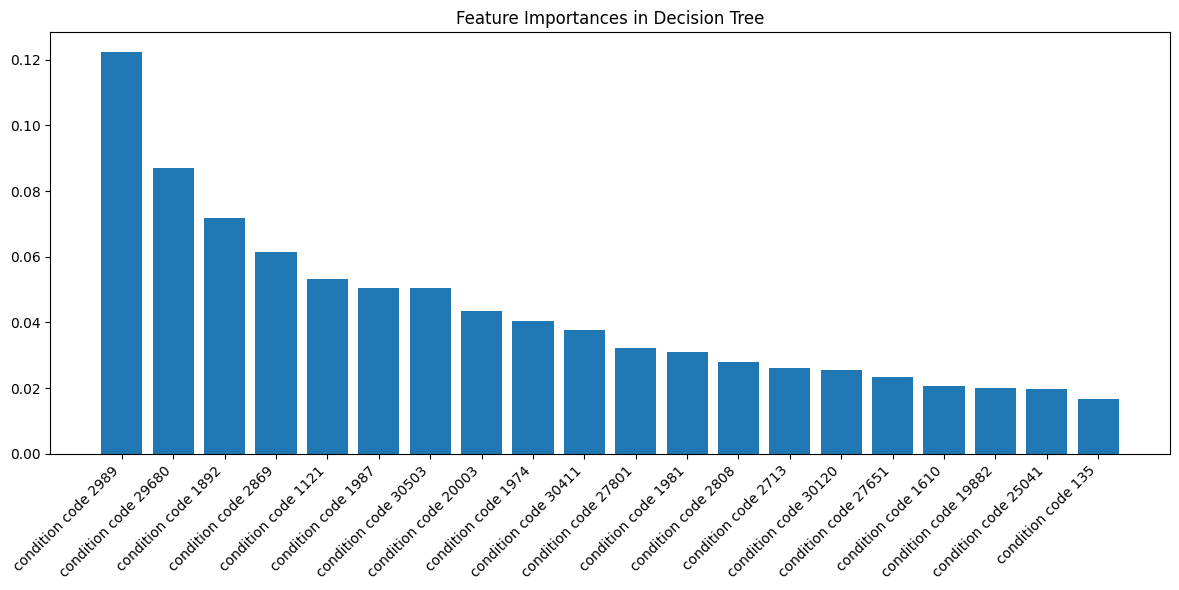

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# === STEP 1: Hook for Embedding Extraction ===
activation = {}

def get_activation(name):
    def hook(test, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

def get_submodule(test, submodule_key):
    for key in submodule_key.split("."):
        test = getattr(test, key)
    return test

# === STEP 2: Register Hook ===
hook_layer_names = [
    'agent.conditions.rnn',
    'agent.procedures.rnn',
    'agent.drugs.rnn'
]

hook_handles = []

# Register hooks and store handles for later removal
for hook_layer_name in hook_layer_names:
    hooked_layer = get_submodule(test, hook_layer_name)
    handle = hooked_layer.register_forward_hook(get_activation(hook_layer_name))
    hook_handles.append(handle)

# === STEP 3: Loop Through Data and Collect Embeddings + Labels ===
X, y = [], []

test.eval()
with torch.no_grad():
    for batch in train_loader:
        _ = test(**batch)  # trigger all hooks
        
        # Collect and concatenate activations from all hooked layers
        batch_embeddings = []
        for name in hook_layer_names:
            batch_embeddings.append(activation[name])
        
        # Stack along feature axis (dim=1) and add to dataset
        concatenated = np.concatenate(batch_embeddings, axis=1)
        X.extend(concatenated)
        y.extend(batch["label"])

# === Build Feature Mapping ===
def build_feature_mapping(dataset):
    all_conditions = set()
    all_procedures = set()
    all_drugs = set()

    for sample in dataset:
        all_conditions.update(flatten_list(sample.get('conditions', [])))
        all_procedures.update(flatten_list(sample.get('procedures', [])))
        all_drugs.update(flatten_list(sample.get('drugs', [])))

    condition_list = sorted(all_conditions)
    procedure_list = sorted(all_procedures)
    drug_list = sorted(all_drugs)
    feature_list = condition_list + procedure_list + drug_list

    index_to_feature = {}
    for i, code in enumerate(feature_list):
        if i < len(condition_list):
            ftype = "condition"
        elif i < len(condition_list) + len(procedure_list):
            ftype = "procedure"
        else:
            ftype = "drug"
        index_to_feature[i] = {"code": code, "type": ftype}

    return index_to_feature

index_to_feature = build_feature_mapping(mimic3_ds_task)

# === STEP 4: Fit Decision Tree ===
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# === STEP 5: Print the Tree ===
readable_feature_names = []
for i in range(X[0].shape[0]):
    if i in index_to_feature:
        info = index_to_feature[i]
        readable_feature_names.append(f"{info['type']} code {info['code']}")
    else:
        readable_feature_names.append(f"unknown_{i}")

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=readable_feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

# === Optional: Evaluate Performance ===
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

In [ ]:
# === Visualize Feature Importances ===
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X, y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Combined Decision Tree")
plt.bar(range(top_k), importances[indices[:top_k]], align="center")
plt.xticks(range(top_k), [readable_feature_names[i] for i in indices[:top_k]], rotation=45, ha="right")
plt.tight_layout()
plt.show()